# Order analysis and A/B testing

Together with the marketing department, we've compiled a list of hypotheses that may help boost revenue.
We need to prioritize these hypotheses, launch an A/B test, and analyze the results.

**Description of the data**

Data used in the first part of the project: Hypotheses dataset -   
•	Hypotheses — brief descriptions of the hypotheses   
•	Reach — user reach, on a scale of one to ten   
•	Impact — impact on users, on a scale of one to ten   
•	Confidence — confidence in the hypothesis, on a scale of one to ten   
•	Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.   

**Data used in the second part of the project:**  

   **Orders dataset:**  
   
•	transactionId — order identifier  
•	visitorId — identifier of the user who placed the order  
•	date — of the order   
•	revenue — from the order  
•	group — the A/B test group that the user belongs to

   **Visits dataset:**   
   
•	date — date   
•	group — A/B test group   
•	visits — the number of visits on the date specified in the A/B test group specified

Data sources:  
/datasets/hypotheses_us.csv  
/datasets/orders_us.csv   
/datasets/visits_us.csv

## Downloading the data and preparing it for analysis

In [1]:
!pip install sidetable

In [2]:
#Let's download relevant libraries
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 210
from datetime import datetime
import scipy.stats as stats
import datetime as dt
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action='ignore')

### Let's look at the data:

In [3]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv')

In [4]:
orders = pd.read_csv('/datasets/orders_us.csv')

In [5]:
visits = pd.read_csv('/datasets/visits_us.csv')

In [6]:
hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 1.4 KB


In [7]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [8]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3 KB


In [9]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


In [10]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [11]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [12]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
visits['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

### Checking the data for missing values

In [14]:
visits.stb.missing(style=True)

,missing,total,percent
date,0,62,0.00%
group,0,62,0.00%
visits,0,62,0.00%


In [15]:
orders.stb.missing(style=True)

,missing,total,percent
transactionId,0,"1,197",0.00%
visitorId,0,"1,197",0.00%
date,0,"1,197",0.00%
revenue,0,"1,197",0.00%
group,0,"1,197",0.00%


### Formatting the datetime columns

In [16]:
orders['date']=pd.to_datetime(orders['date'],format='%Y-%m-%d')

In [17]:
visits['date']=pd.to_datetime(visits['date'],format='%Y-%m-%d') 

### Checking and treating duplicates

In [18]:
orders[orders['visitorId'].duplicated()]

,transactionId,visitorId,date,revenue,group
41,2594268419,237748145,2019-08-15,20.8,A
91,3176574859,2742574263,2019-08-22,275.9,B
95,372616894,457167155,2019-08-22,20.2,B
98,1962247337,2706377257,2019-08-01,110.7,A
112,1638982251,3062433592,2019-08-01,135.3,B
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,20.8,B
1183,1458356232,963407295,2019-08-14,80.0,A
1184,1329499668,2949041841,2019-08-14,160.7,B
1189,4082620617,393266494,2019-08-14,490.4,B


There're some duplicates, but let's see the original rows as well, alongside the duplicates, to better understand the nature of the duplicates. We want to make sure that no users are present in both A and B groups.

In [19]:
orders[orders['visitorId'].duplicated(keep=False)].sort_values(by=['visitorId'],ascending=False)

,transactionId,visitorId,date,revenue,group
662,1811671147,4266935830,2019-08-29,1220.2,A
682,1216533772,4266935830,2019-08-29,1220.2,B
60,1421016313,4256040402,2019-08-16,875.5,B
263,2575861846,4256040402,2019-08-18,170.8,B
187,2048878902,4256040402,2019-08-17,25.8,A
...,...,...,...,...,...
26,2223239646,199603092,2019-08-15,55.7,A
823,2971973105,199603092,2019-08-27,45.9,A
134,62794304,199603092,2019-08-22,110.3,A
71,3679129301,8300375,2019-08-01,165.7,B


In [20]:
#Let's identify the number of groups each user is assigned to and see whether there are any users, who are assigned to two
#groups
order_duplicates = orders.groupby(['visitorId'])['group'].nunique().sort_values(ascending=False).reset_index()
order_duplicates.head()

,visitorId,group
0,2654030115,2
1,3891541246,2
2,3941795274,2
3,1404934699,2
4,351125977,2


We can see that there're some users who are assigned to both groups A and B. We will remove those users from the dataframe. For that we will select users who assigned to both groups into separate list, and then select from the original 'orders' dataset users, who are NOT in the list.

In [21]:
visitor_drop = orders.groupby('visitorId')['group'].nunique().reset_index().query('group !=1')['visitorId'].to_list()

In [22]:
orders_filt = orders[~orders['visitorId'].isin(visitor_drop)]
orders_filt

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


## Part 1. Prioritizing Hypotheses

Impact, confidence, effort (ICE) is one of the most popular ways of prioritizing problems:
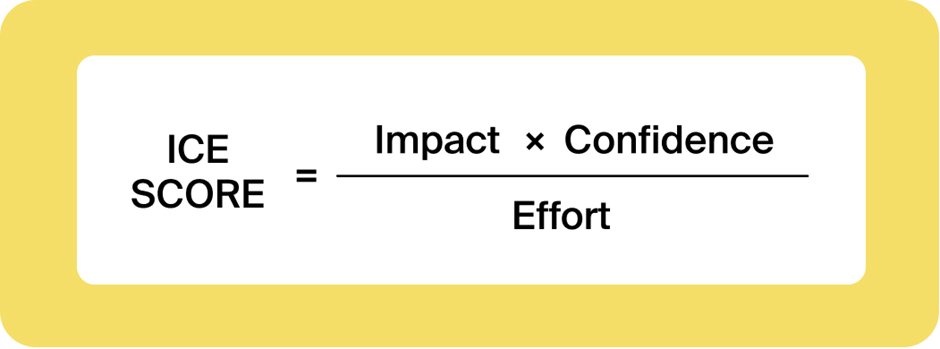

There's also a modified version, RICE:
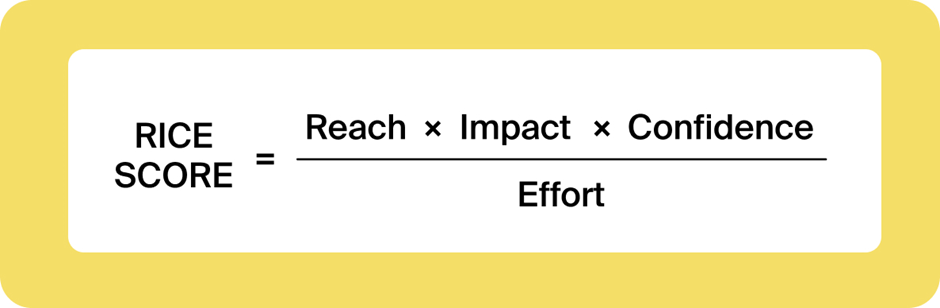
 
**RICE has four components:**  

- Reach — how many users will be affected by the update you want to introduce  
- Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product  
- Confidence — how sure you are that your product will affect them in this way  
- Effort — how much will it cost to test the hypothesis

**We will do the following:**  
•	Apply the ICE framework to prioritize hypotheses, and then sort them in descending order of priority.  
•	Apply the RICE framework to prioritize hypotheses, and then sort them in descending order of priority.

In [23]:
hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1


### ICE

In [24]:
hypotheses['ICE'] = (hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']

In [25]:
hypotheses_ICE = hypotheses[['Hypothesis', 'ICE']].round().sort_values(by='ICE', ascending=False)
hypotheses_ICE

,Hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.0
0,Add two new channels for attracting traffic. This will bring 30% more users,13.0
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.0
6,Show banners with current offers and sales on the main page. This will boost conversion,8.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.0
1,Launch your own delivery service. This will shorten delivery time,2.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.0
4,Change the background color on the main page. This will increase user engagement,1.0
5,Add a customer review page. This will increase the number of orders,1.0


### RICE

In [26]:
hypotheses['RICE'] = (hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']

In [27]:
hypotheses_RICE = hypotheses[['Hypothesis', 'RICE']].round().sort_values(by='RICE', ascending=False)
hypotheses_RICE

,Hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


<Figure size 1440x792 with 0 Axes>

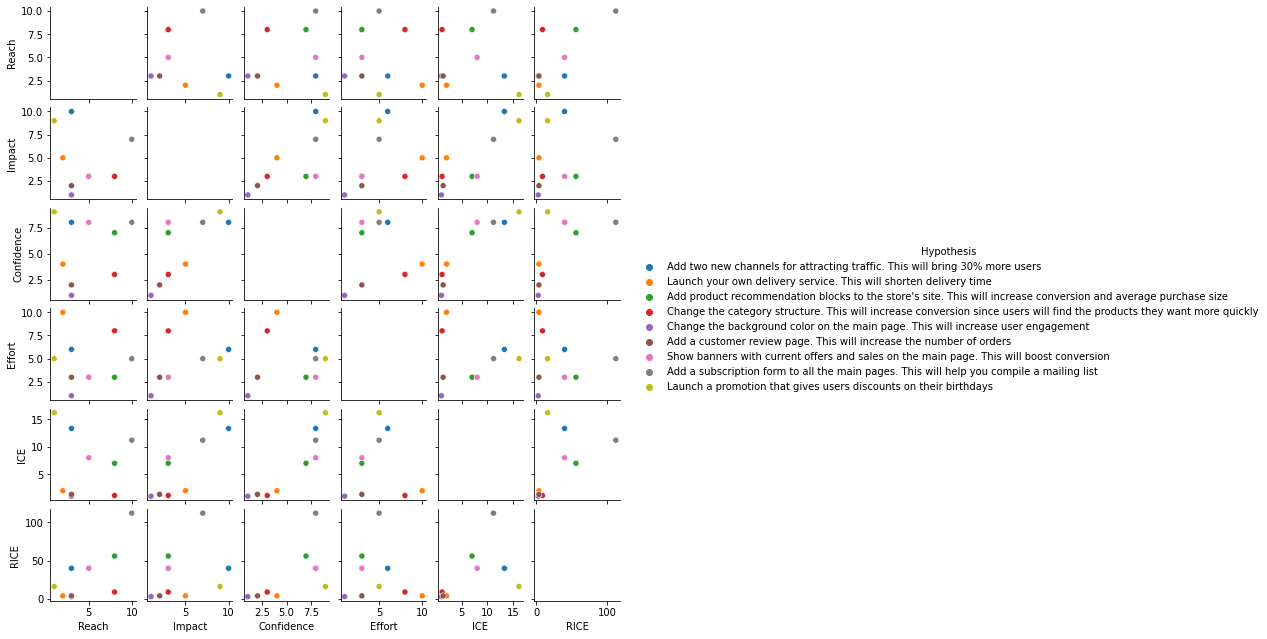

In [28]:
import seaborn
plt.figure(figsize=(20,11))
seaborn.pairplot(hypotheses, hue="Hypothesis", height=1.5);

**Conclusions**  

Based on the ICE framework, the hypothesis 8 (**Launch a promotion that gives users discounts on their birthdays**) is of highest priority: it has the largest impact and high confidence, and lowest effort of test application. However, once we apply RICE framework, the hypothesis 7 (**Add a subscription form to all the main pages. This will help you compile a mailing list)** gets the higher priority, and hypothesis 8 drops 4 point down. This is because the RICE framework has also REACH parameter. Obviously, hypothesis 7, which has on the 3rd place in ICE framework, rises to the first place as it has much higher reach. 

## Part 2. A/B Test Analysis

### Cumulative revenue by group

Let's graph cumulative revenue by group. For that we will group the orders_filt dataset by date and group, and count unique purchases, buyers, and total revenue per day.

In [29]:
orders_cumul = orders_filt.groupby(['date', 'group']).agg({'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum'}).reset_index()
orders_cumul.columns = ['date', 'group', 'purchases', 'buyers', 'revenue']
orders_cumul.head()

,date,group,purchases,buyers,revenue
0,2019-08-01,A,23,19,2266.6
1,2019-08-01,B,17,17,967.2
2,2019-08-02,A,19,18,1468.3
3,2019-08-02,B,23,22,2568.1
4,2019-08-03,A,24,24,1815.2


Now we will calculate cumulative revenue using cumsum() function.

In [30]:
orders_cumul['cumul_rev']=orders_cumul['revenue'].cumsum()
orders_cumul.head()

,date,group,purchases,buyers,revenue,cumul_rev
0,2019-08-01,A,23,19,2266.6,2266.6
1,2019-08-01,B,17,17,967.2,3233.8
2,2019-08-02,A,19,18,1468.3,4702.1
3,2019-08-02,B,23,22,2568.1,7270.2
4,2019-08-03,A,24,24,1815.2,9085.4


We will now split the resulting dataset into two different datasets - for group A and group B.

In [31]:
orders_cumulA = orders_cumul[orders_cumul.group=="A"]
orders_cumulA.head()

,date,group,purchases,buyers,revenue,cumul_rev
0,2019-08-01,A,23,19,2266.6,2266.6
2,2019-08-02,A,19,18,1468.3,4702.1
4,2019-08-03,A,24,24,1815.2,9085.4
6,2019-08-04,A,11,11,675.5,10832.5
8,2019-08-05,A,22,22,1398.0,13762.1


In [32]:
orders_cumulB = orders_cumul[orders_cumul.group=="B"]
orders_cumulB.head()

,date,group,purchases,buyers,revenue,cumul_rev
1,2019-08-01,B,17,17,967.2,3233.8
3,2019-08-02,B,23,22,2568.1,7270.2
5,2019-08-03,B,14,14,1071.6,10157.0
7,2019-08-04,B,14,13,1531.6,12364.1
9,2019-08-05,B,21,21,1449.3,15211.4


Let's now plot the graph:

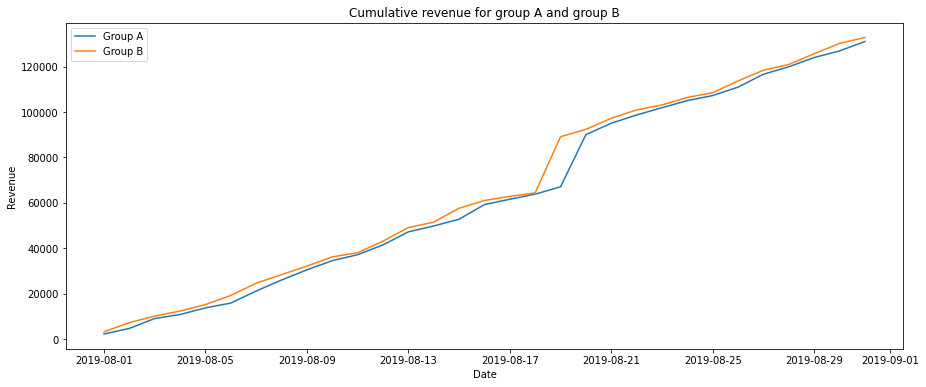

In [33]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orders_cumulA['date'], orders_cumulA['cumul_rev'], label='Group A')
plt.plot(orders_cumulB['date'], orders_cumulB['cumul_rev'], label='Group B')
plt.title('Cumulative revenue for group A and group B')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.legend();

The cumulative metrics of group A are consistently slightly lower than those of the group B. Around the last third of the test there's a sharp increase in cumulative revenue for both groups. Maybe the average order sizes became larger or the number of orders has increased.

### Cumulative average order size by group

Let's graph cumulative average order size by group, which is revenue divided by purchases. For that we will apply cumsum() on the number of total daily purchases. And then we will divide the cumulative revenue by cumulative purchases. We will do that for groups A and B separately.

In [34]:
#Group A:
orders_cumulA['cumul_orders']=orders_cumulA['purchases'].cumsum()
orders_cumulA['cumul_avg_order']=orders_cumulA['cumul_rev']/orders_cumulA['cumul_orders']
orders_cumulA.head()

,date,group,purchases,buyers,revenue,cumul_rev,cumul_orders,cumul_avg_order
0,2019-08-01,A,23,19,2266.6,2266.6,23,98.547826
2,2019-08-02,A,19,18,1468.3,4702.1,42,111.954762
4,2019-08-03,A,24,24,1815.2,9085.4,66,137.657576
6,2019-08-04,A,11,11,675.5,10832.5,77,140.681818
8,2019-08-05,A,22,22,1398.0,13762.1,99,139.011111


In [35]:
#Group B:
orders_cumulB['cumul_orders']=orders_cumulB['purchases'].cumsum()
orders_cumulB['cumul_avg_order']=orders_cumulB['cumul_rev']/orders_cumulB['cumul_orders']
orders_cumulB.head()

,date,group,purchases,buyers,revenue,cumul_rev,cumul_orders,cumul_avg_order
1,2019-08-01,B,17,17,967.2,3233.8,17,190.223529
3,2019-08-02,B,23,22,2568.1,7270.2,40,181.755000
5,2019-08-03,B,14,14,1071.6,10157.0,54,188.092593
7,2019-08-04,B,14,13,1531.6,12364.1,68,181.825000
9,2019-08-05,B,21,21,1449.3,15211.4,89,170.914607


Let's calculate average order size for each group by dividing revenue by purchases.

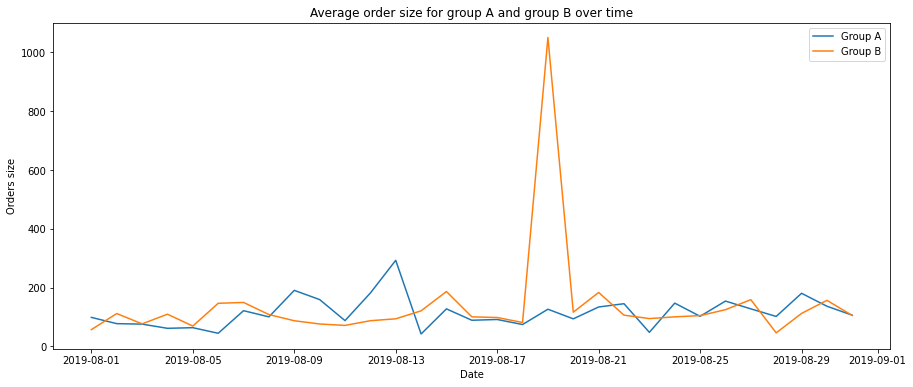

In [36]:
orders_cumulA['avg_order']=orders_cumulA['revenue']/orders_cumulA['purchases']
orders_cumulB['avg_order']=orders_cumulB['revenue']/orders_cumulB['purchases']
plt.plot(orders_cumulA['date'], orders_cumulA['avg_order'], label='Group A')
plt.plot(orders_cumulB['date'], orders_cumulB['avg_order'], label='Group B')
plt.title('Average order size for group A and group B over time')
plt.ylabel('Orders size')
plt.xlabel('Date')
plt.legend();

The average order size fluctuates for both groups throughout the test, and then it spikes for group B around August 20th (the beginning of the last third of the test).

Let's plot graph for cumulative average order size which will show the tendencies for both groups.

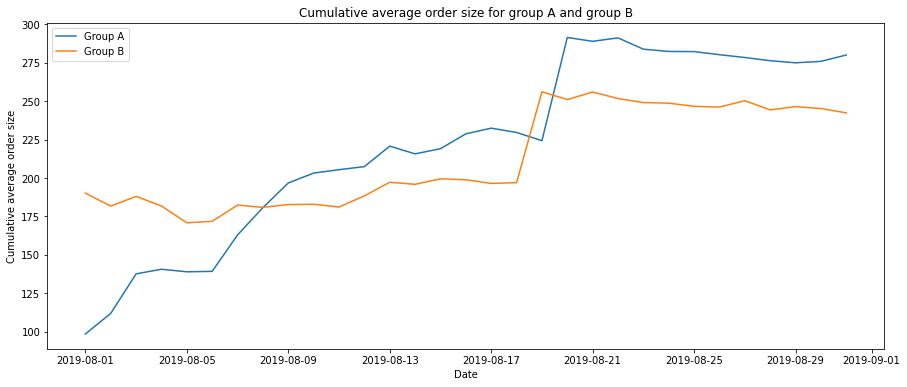

In [37]:
plt.plot(orders_cumulA['date'], orders_cumulA['cumul_avg_order'], label='Group A')
plt.plot(orders_cumulB['date'], orders_cumulB['cumul_avg_order'], label='Group B')
plt.title('Cumulative average order size for group A and group B')
plt.ylabel('Cumulative average order size')
plt.xlabel('Date')
plt.legend();

The cumulative average order size isn't increasing for group B until around August 20th, at which point there's a sharp increase, after which comes stability.   
For group A ther's a stable increase until August 20, and then there's a sharp increase, after which it straightens out. 
Until August 20 the tendencies are almost opposite, with group A cumulative average order size starting low, gradually increasing, and eventually surpassing group B.

### Relative difference in cumulative average order size

Let's graph the relative difference in cumulative average order size for group B compared with group A.

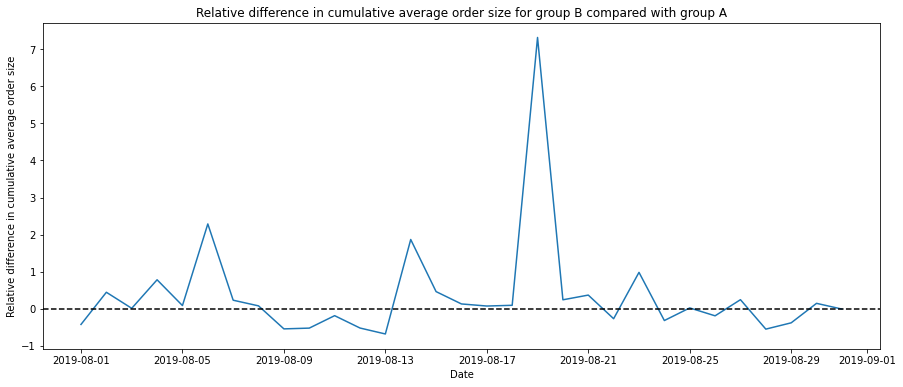

In [38]:
### gathering the data into one DataFrame
merged_cumul_orders = orders_cumulA.merge(orders_cumulB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.plot(merged_cumul_orders['date'], (merged_cumul_orders['revenueB']/merged_cumul_orders['purchasesB'])/(merged_cumul_orders['revenueA']/merged_cumul_orders['purchasesA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Relative difference in cumulative average order size for group B compared with group A')
plt.ylabel('Relative difference in cumulative average order size')
plt.xlabel('Date'); 

The relative difference in cumulative average order size for group B compared with group A fluctuates around 0, with accasional spikes around August 6th and 14th, with a sharp spike around August 20th. Indeed, we see above that average order size for group B spikes around that date.

### Conversion rate by group

Let's calculate each group's conversion rate as the ratio of orders to the number of visits for each day, and plot the daily conversion rates of the two groups.

In [39]:
#Group A - dates and number of visits per day
visitsA = visits[visits.group=="A"]
visitsA = visitsA.drop(['group'], axis=1)
visitsA.head()

,date,visits
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [40]:
#Group B - dates and number of visits per day
visitsB = visits[visits.group=="B"]
visitsB = visitsB.drop(['group'], axis=1)
visitsB.head()

,date,visits
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [41]:
#Let's merge the data on orders with data on visits per day for group A and calculate cumulative visits:
orders_visitsA = orders_cumulA.merge(visitsA, how='left', on='date')
orders_visitsA['cumul_visits']=orders_visitsA['visits'].cumsum()
orders_visitsA.head()

,date,group,purchases,buyers,revenue,cumul_rev,cumul_orders,cumul_avg_order,avg_order,visits,cumul_visits
0,2019-08-01,A,23,19,2266.6,2266.6,23,98.547826,98.547826,719,719
1,2019-08-02,A,19,18,1468.3,4702.1,42,111.954762,77.278947,619,1338
2,2019-08-03,A,24,24,1815.2,9085.4,66,137.657576,75.633333,507,1845
3,2019-08-04,A,11,11,675.5,10832.5,77,140.681818,61.409091,717,2562
4,2019-08-05,A,22,22,1398.0,13762.1,99,139.011111,63.545455,756,3318


In [42]:
#Let's merge the data on orders with data on visits per day for group B and calculate cumulative visits:
orders_visitsB = orders_cumulB.merge(visitsB, how='left', on='date')
orders_visitsB['cumul_visits']=orders_visitsB['visits'].cumsum()
orders_visitsB.head()

,date,group,purchases,buyers,revenue,cumul_rev,cumul_orders,cumul_avg_order,avg_order,visits,cumul_visits
0,2019-08-01,B,17,17,967.2,3233.8,17,190.223529,56.894118,713,713
1,2019-08-02,B,23,22,2568.1,7270.2,40,181.755000,111.656522,581,1294
2,2019-08-03,B,14,14,1071.6,10157.0,54,188.092593,76.542857,509,1803
3,2019-08-04,B,14,13,1531.6,12364.1,68,181.825000,109.400000,770,2573
4,2019-08-05,B,21,21,1449.3,15211.4,89,170.914607,69.014286,707,3280


In [43]:
#Let's calculate the conversion for groups A and B:
orders_visitsA['conversion']=orders_visitsA['purchases']/orders_visitsA['visits']
orders_visitsB['conversion']=orders_visitsB['purchases']/orders_visitsB['visits']

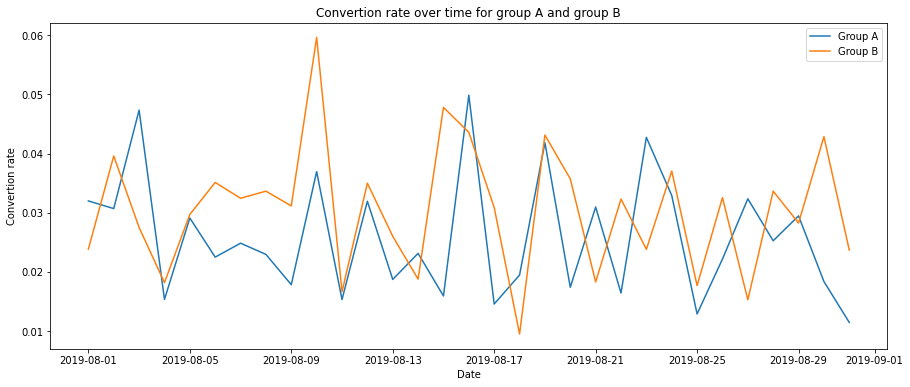

In [44]:
#Plotting the graph:
plt.plot(orders_visitsA['date'], orders_visitsA['conversion'], label='Group A')
plt.plot(orders_visitsB['date'], orders_visitsB['conversion'], label='Group B')
plt.title('Convertion rate over time for group A and group B')
plt.ylabel('Convertion rate')
plt.xlabel('Date')
plt.legend();

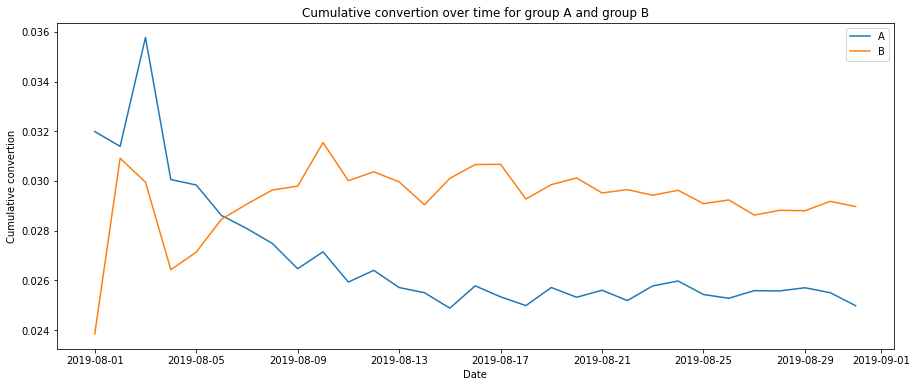

In [45]:
# calculating cumulative conversion for group A and group B:
orders_visitsA['cumul_conversion'] = orders_visitsA['cumul_orders']/orders_visitsA['cumul_visits']
orders_visitsB['cumul_conversion'] = orders_visitsB['cumul_orders']/orders_visitsB['cumul_visits']

# plotting the graphs
plt.plot(orders_visitsA['date'], orders_visitsA['cumul_conversion'], label='A')
plt.plot(orders_visitsB['date'], orders_visitsB['cumul_conversion'], label='B')
plt.title('Cumulative convertion over time for group A and group B')
plt.ylabel('Cumulative convertion')
plt.xlabel('Date')
plt.legend();

In [46]:
#overall conversion Group A:
(orders_visitsA['purchases'].sum()/orders_visitsA['visits'].sum()).round(3)

0.025

In [47]:
#overall conversion Group B:
(orders_visitsB['purchases'].sum()/orders_visitsB['visits'].sum()).round(3)

0.029

The overall average conversion rate for group A is 0.025 and for group B - 0.029. From the regular conversion graph by groups it's hard to tell which segment is better, since the daily results fluctuate strongly. However, from the cumulative conversion over time we see that group A stars high and then decreases and stabilizes by the end of the period. Group B starts low, fluctuates, grows, and stabilizes by the end of the period. In general, it looks like the cumulative conversion rate for group B consistantly surpasses the one by group A.

### Number of orders per user

Let's plot a scatter chart of the number of orders per user by dividing the number of total purchases by the number of buyers. But first, we will find out the overall number of orders per user.

In [48]:
#Number of orders per user - group A:
total_orders_per_userA = (orders_visitsA['purchases'].sum()/orders_visitsA['buyers'].sum()).round(3)
total_orders_per_userA

1.024

In [49]:
#Number of orders per user - group B:
total_orders_per_userB = (orders_visitsB['purchases'].sum()/orders_visitsB['buyers'].sum()).round(3)
total_orders_per_userB

1.007

Let's first plot a distribution histogram with the number of orders per user.

In [50]:
ordersByUsers = (
    orders_filt.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


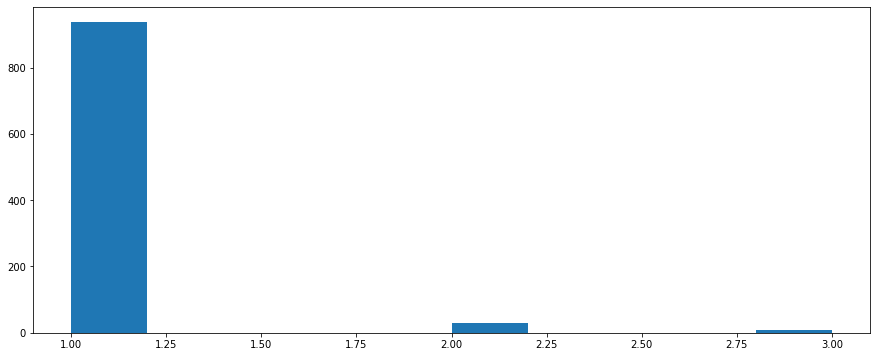

In [51]:
plt.hist(ordersByUsers['orders']);

The majority of customers placed only one order. However, ther're some who placed two to three apiece.
Let's plot a scatter chart with the number of orders per user:

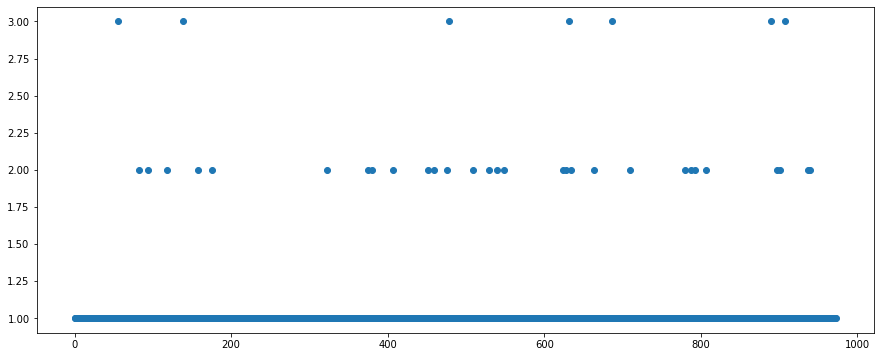

In [52]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']);

We see that the majority of the users made 1 order only, with accasional outliers with 2 or 3 orders.

### 95th and 99th percentiles for the number of orders per user

Let's calculate the 95th and 99th percentiles for the number of orders per user and define the point at which a data point becomes an anomaly.

In [53]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


No more than 5% of users placed more than 1 order, and 1% of users made more than 2 orders.

### Order prices

Let's plot a scatter chart of order prices.

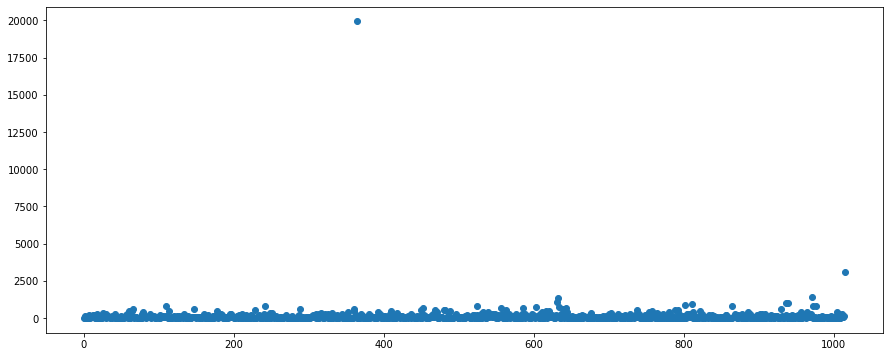

In [54]:
x_values = pd.Series(range(0, len(orders_filt['revenue'])))
plt.scatter(x_values, orders_filt['revenue']);

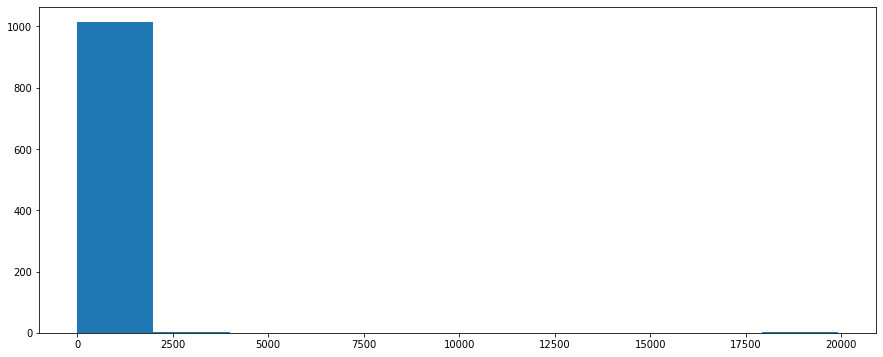

In [55]:
plt.hist(orders_filt['revenue']);

In [56]:
orders_filt['revenue'].describe()

count     1016.000000
mean       130.770866
std        648.079810
min          5.000000
25%         20.775000
50%         50.100000
75%        126.950000
max      19920.400000
Name: revenue, dtype: float64

We see that the distribution of the order prices is not very wide - 75% of users made orders of 127 or less. There are occasional anomalies.

### 95th and 99th percentiles of order prices

Let's calculate the 95th and 99th percentiles of order prices and define the point at which a data point becomes an anomaly.

In [57]:
print(np.percentile(orders_filt['revenue'], [95, 99]))

[414.275 830.3  ]


**Conclusion:**  

No more than 5% of users placed an order of more than 414.275, and 1% of users placed an order of more than 830.3.

### Statistical significance of the difference in conversion between the groups - raw data.

Let's find the statistical significance of the difference in conversion between the groups using the raw data.

**We'll test the following hypotheses:**  

Ho - null hypothesis: There's no difference in conversion rate between the groups. The conversion rates are the same.  

H1 hypothesis: There's a difference in conversion rate between the groups. The conversion rates are NOT the same.

Let's calculate the statistical significance of the difference in conversion between the groups.
We'll create the variables ordersByUsersA and ordersByUsersB to store the columns ['userId', 'orders']. For users with at least one order, we'll indicate the number of orders made.

Then, we'll declare the variables sampleA and sampleB, with users from different groups and corresponding numbers of orders. This is necessary to prepare the samples for the Mann-Whitney test.

We'll apply the criterion and format the p-value by rounding it to three decimal places.
SampleA stores a sample where each element is the number of orders made by a certain user. So the number of sampleA elements is the number of users, and the sum of all the elements is the number of orders. To get the group's conversion rate, we'll need to divide the sum of the orders by the number of users. Using the mean() method, we'll find the mean for sampleA. We'll find the conversion rate for group B in a similar way: sampleB.mean().
Let's print the relative conversion gain for group B: group B conversion / group A conversion - 1. We'll round the value to three decimal places.

In [58]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [59]:
ordersByUsersA = orders_filt[orders_filt['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA

,userId,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1
...,...,...
440,4227830084,1
441,4237561104,1
442,4243832526,1
443,4259830713,1


In [60]:
ordersByUsersB = orders_filt[orders_filt['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB

,userId,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1
...,...,...
523,4251115836,1
524,4258103007,1
525,4279090005,1
526,4281247801,1


In [61]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('The p-value is', "{0:}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('The relative conversion gain of group B is', "{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

The p-value is 0.011018084110014696
The relative conversion gain of group B is 0.160


**Conclusion:**   

Based on the raw data, there is a difference between groups A and B.
The first row of the output gives us the p-value, 0.011, which is smaller than 0.05. So we reject the null hypothesis that there's not a statistically significant difference in conversion between the groups. But the relative gain of group B is 16% (the second row of the output).

### Statistical significance of the difference in average order size between the groups - raw data.

Let's find the statistical significance of the difference in average order size between the groups using the raw data.

**We'll test the following hypotheses:**  

Ho - null hypothesis: There's no difference in average order size between the groups. The average order sizes are the same.  

H1 hypothesis: There's a difference in average order size between the groups. The average order sizes are NOT the same. 

To calculate the statistical significance of the difference in the segments' average order size, we'll pass the data on revenue to the mannwhitneyu() criterion.
We'll also find the relative difference in average order size between the groups:

In [62]:
print('The P-values is','{0:}'.format(stats.mannwhitneyu(orders_filt[orders_filt['group']=='A']['revenue'], orders_filt[orders_filt['group']=='B']['revenue'])[1]))
print('The relative difference in average order size is', '{0:.3f}'.format(orders_filt[orders_filt['group']=='B']['revenue'].mean()/orders_filt[orders_filt['group']=='A']['revenue'].mean()-1)) 

The P-values is 0.8622329690015668
The relative difference in average order size is 0.278


**Conclusion:**  

The p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis, and we can conclude that average order size doesn't differ between the groups. Nonetheless, the average order size for group B is bigger than it is for group A.

The 95th and 99th percentiles for average order size, which we found above, were roughly 413 and 830. The 95th and 99th percentiles for the number of orders per user were 2 and 3 orders.

### Statistical significance of the difference in conversion between the groups - filtered data

Let's find the statistical significance of the difference in conversion between the groups using the filtered data.

**We'll test the following hypotheses:**  

Ho - null hypothesis: There's no difference in conversion rate between the groups, when using the filtered data. The conversion rate is the same.  

H1 hypothesis: There's a difference in conversion rate between the groups, when using the filtered data. The conversion rate is NOT the same. 

Let's define anomalous users as those who place more than 1 order or one order bigger than 500. Thus we'll remove the 5 percent of users with the largest numbers of orders and from 1 percent to 5 percent of the users with the most expensive orders. Let's make data slices with the users who placed more than 1 order (usersWithManyOrders) and the users who placed orders for more than 500 (usersWithExpensiveOrders). We'll join them in a table called abnormalUsers.

Let's find the total number of anomalous users using the shape() method.

In [63]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 1]['userId']], axis = 0)

In [64]:
usersWithExpensiveOrders = orders_filt[orders_filt['revenue'] > 500]['visitorId']

In [65]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
928     204675465
33      249864742
684     358944393
36      366673373
dtype: int64
(72,)


We have 72 anomalous users in total.
Let's try to find out how their actions affected the test results. We'll calculate the statistical significance of the differences in conversion between the groups, using filtered data. First we'll prepare samples of the number of orders per user for each test group:


In [66]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

Let's apply the statistical Mann-Whitney criterion to the resulting samples:

In [67]:
print('The P-value is:', "{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('The relative conversion gain of group B is', "{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

The P-value is: 0.010
The relative conversion gain of group B is 0.186


**Conclusion:**  

The results for conversion almost didn't change - the p-value slightly dropped, which only strengthens the conclusion that there's no significant difference between the conversion rates in two groups.

### Statistical significance of the difference in average order size between the groups - filtered data.

Let's find the statistical significance of the difference in average order size between the groups using the filtered data.

**We'll test the following hypotheses:**  

Ho - null hypothesis: There's no difference in average order size between the groups, when using filtered data. The average order sizes are the same.  

H1 hypothesis: There's a difference in average order size between the groups, when using filtered data. The average order sizes are NOT the same.

In [68]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders_filt[np.logical_and(
        orders_filt['group']=='A',
        np.logical_not(orders_filt['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders_filt[np.logical_and(
        orders_filt['group']=='B',
        np.logical_not(orders_filt['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    orders_filt[np.logical_and(orders_filt['group']=='B',np.logical_not(orders_filt['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders_filt[np.logical_and(
        orders_filt['group']=='A',
        np.logical_not(orders_filt['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.992
0.016


**Conclusion:** 

The p-value has increased, but now the difference between the segments is about 2% instead of 28%. The difference has shrinked in the filtered data.

## Part 3. General conclusions

**1. The Data:**
-	No missing values were found in the datasets. 
-	There're some users who were assigned to both groups A and B. We have removed those users from the dataset. 
-	We’ve formatted the date columns using to_datetime() method.

**2. The Test**   

  **Part 1. Prioritizing Hypotheses**
We have applied the ICE and RICE framework to prioritize the hypotheses. 
Based on the ICE framework, the hypothesis 8 (Launch a promotion that gives users discounts) is of highest priority: it had the largest impact and high confidence, and lowest effort of test application. However, once we apply RICE framework, the hypothesis 7 (Add a subscription form to all the main pages) got the higher priority, and hypothesis 8 droped 4 point down to the 5th place. This is because the RICE framework also has REACH parameter. Obviously, hypothesis 7, which was on the 3rd place in the ICE framework, rose to the first place as it had much wider reach.

   **Part 2. A/B Test Analysis**   
   
   **1. Cumulative revenue by group**  
   
   We’ve plotted a graph of cumulative revenue by group. The cumulative metrics of group A were consistently slightly lower than those of the group B. Around the last third of the test there's a sharp increase in cumulative revenue for both groups. Maybe the average order sizes became larger, or the number of orders has increased.  

  **2. Cumulative average order size by group**  
  
  We’ve plotted a graph of cumulative average order size by group, which is revenue divided by purchases. The average order size fluctuated for both groups throughout the test, and then it spiked for group B around August 20th (the beginning of the last third of the test).
We’ve plotted a graph of cumulative average order size which showed the tendencies for both groups. The cumulative average order size hasn’t increased for group B until around August 20th, at which point there's a sharp increase, after which comes stability.
For group A there's a stable increase until August 20, and then there's a sharp increase, after which it straightens out. Until August 20 the tendencies are almost opposite, with group A cumulative average order size starting low, gradually increasing, and eventually surpassing group B.  

  **3. Relative difference in cumulative average order size**  
  
  We’ve plotted a graph of relative difference in cumulative average order size for group B compared with group A.
The relative difference in cumulative average order size for group B compared with group A fluctuates around 0, with occasional spikes around August 6th and 14th, with a sharp spike around August 20th. Indeed, we saw above that average order size for group B spikes around that date.  

  **4. Conversion rate by group**  
  
  We’ve calculated each group's conversion rate as the ratio of orders to the number of visits for each day and plotted the daily conversion rates of the two groups and cumulative conversion by group over time. The overall average conversion rate for group A is 0.025 and for group B - 0.029. From the regular conversion graph by groups it's hard to tell which segment is better, since the daily results fluctuate strongly. However, from the cumulative conversion over time we see that group A stars high and then decreases and stabilizes by the end of the period. Group B starts low, fluctuates, grows, and stabilizes by the end of the period. In general, it looks like the cumulative conversion rate for group B consistantly surpasses the one by group A.
  
  **5. Number of orders per user**  
  
  We’ve plotted a scatter chart of the number of orders per user by dividing the number of total purchases by the number of buyers. Most customers placed only one order. However, there’re some who placed two to three apiece. The overall number of orders per user as 1.024 for group A and 1.007 for grout B.   
  
  **6. 95th and 99th percentiles for the number of orders per user**  
  
  We’ved calculated the 95th and 99th percentiles for the number of orders per user to define at which point a data point became an anomaly. No more than 5% of users placed more than 1 order, and 1% of users made more than 2 orders.  
  
  **7. Order prices**   
  
  We’ve plotted a scatter chart of order prices and saw that the distribution of the order prices is not very wide - 75% of users made orders of 127 or less. There are occasional anomalies.  
  
  **8. 95th and 99th percentiles of order prices**  
  
  We’ve calculated the 95th and 99th percentiles of order prices and defined the point at which a data point became an anomaly. No more than 5% of users placed an order of more than 414.275, and 1% of users placed an order of more than 830.3.  
  
  **9. Statistical significance of the difference in conversion between the groups - raw data**   
  
  We’ve found the statistical significance of the difference in conversion between the groups using the raw data. For that we’ve created the variables ordersByUsersA and ordersByUsersB to store the columns ['userId', 'orders']. For users with at least one order, we've indicate the number of orders made.
Then, we've declared the variables sampleA and sampleB, with users from different groups and corresponding numbers of orders. This was necessary to prepare the samples for the Mann-Whitney test.
We've applied the criterion and formatted the p-value by rounding it to three decimal places. SampleA stored a sample where each element is the number of orders made by a certain user. So the number of sampleA elements was the number of users, and the sum of all the elements was the number of orders. To get the group's conversion rate, we've divided the sum of the orders by the number of users. Using the mean() method, we’ve found the mean for sampleA. We found the conversion rate for group B in a similar way: sampleB.mean().We’ve also printed the relative conversion gain for group B: group B conversion / group A conversion - 1.
**Based on the raw data, we rejected the Null hypothesis and concluded there was a difference between groups A and B**.   
The first row of the output gave us the p-value, 0.011, which is smaller than 0.05. So, we’ve rejected the null hypothesis that there's not a statistically significant difference in conversion between the groups. The relative gain of group B is 16% (the second row of the output).   

  **10. Statistical significance of the difference in average order size between the groups - raw data**   
  
  We’ve found the statistical significance of the difference in average order size between the groups using the raw data. To calculate the statistical significance of the difference in the segments' average order size, we've passed the data on revenue to the mannwhitneyu() criterion. We've also found the relative difference in average order size between the groups.
The p-value is considerably higher than 0.05, so **based on the raw data, there's no reason to reject the null hypothesis, and we can conclude that average order size doesn’t differ between the groups.** Nonetheless, the average order size for group B is bigger than it is for group A. 
The 95th and 99th percentiles for average order size, which we found above, were roughly 413 and 830. The 95th and 99th percentiles for the number of orders per user were 2 and 3 orders.   

  **11. Statistical significance of the difference in conversion between the groups - filtered data**  
  
  We’ve found the statistical significance of the difference in conversion between the groups using the filtered data without anomalies. We’ve defined anomalous users as those who place more than 1 order or one order bigger than 500. Thus, we've removed the 5 percent of users with the largest numbers of orders and from 1 percent to 5 percent of the users with the most expensive orders. We have found 72 anomalous users in total. We've calculated the statistical significance of the differences in conversion between the groups, using filtered data. First, we've prepared samples of the number of orders per user for each test group, then we’ve applied the statistical Mann-Whitney criterion to the resulting samples. 
The results for conversion almost didn't change - the p-value slightly dropped, which only strengthens the conclusion that there's a significant difference between the conversion rates in two groups, therefore, we reject the null hypothesis.  

   **12. Statistical significance of the difference in average order size between the groups - filtered data**
We’ve found the statistical significance of the difference in average order size between the groups using the filtered data. After removing the anomalies, the p-value has increased, which only strengthened the conclusion, that **there’s no significant difference in average order sizes between the groups** and now the difference between the segments is about 2% instead of 28%. The difference has shrinked even more in the filtered data, therefore, we failed to reject the null hypothesis.


   **Part 3. General conclusions** 
   
   •	There's a statistically significant difference in conversion between the groups, according to both the raw and the filtered data.   
   •	The raw data didn't show a statistically significant difference between the groups in terms of average purchase size. And after the anomalies were removed, the seeming difference has shrinked even more.  
   •	The graph of the relative difference in cumulative average order size showed fluctuations around 0 with occasional spikes.  
   •	The graph for the cumulative revenue by group showed that the results of group A are consistently slightly lower than those of group B. Around the last third of the test there's a sharp increase in cumulative revenue for both groups.   
   •	The graph for the cumulative average order size showed until August 20 the tendencies are almost opposite, with group A cumulative average order size starting low, gradually increasing, and eventually surpassing group B.  
   •	From the regular conversion graph by groups it's hard to tell which segment is better, since the daily results fluctuate strongly. However, the cumulative conversion graph shows that the cumulative conversion rate for group A consistantly surpasses the one by group B.

**Before conducting the test, we need to determine the sample size, duration, and the metric we want to improve. In this case, we have two metrics, but only one of them shows a statistically significant difference, which is enough to use variant B - Stop the test, conclude that there is no difference between the groups.**